I really like the idea of having an image of a molecule that I can re-construct the molecule from. It's been possible to do this with SVGs from the RDKit for a while by adding chemical metadata. There's a desciption of that [here](https://github.com/rdkit/UGM_2018/blob/master/Notebooks/Landrum_Whats_New.ipynb) that shows both adding the metadata and constructing the molecule from it.

An aside: Since you can now add SVGs to powerpoint documents, I was super excited about the idea of being able to have molecule images in my Powerpoint decks together with the metadata to reconstruct those molecules. Unforunately, as of this writing at least, Powerpoint strips out all the metadata that it doesn't recognize, so the chemistry information all ends up being removed. Sad...

Anyway, back to the point of this blog post: I wanted to do the same thing with the PNGs that the RDKit can generate, but kept getting stuck on how to do this from the C++ side. Today I realized that it's quite easy to do it in Python and that this would possibly be useful to most RDKit users. Thus this post.

If anyone knows of a decent C++ snippet or library with an BSD-compatible license (this rules out [exiv2](https://www.exiv2.org/), which otherwise looks like the perfect thing) that shows how to add metadata to a PNG, please do let me know.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 350,300
from PIL import Image
from io import BytesIO
import rdkit
print(rdkit.__version__)

2020.03.4


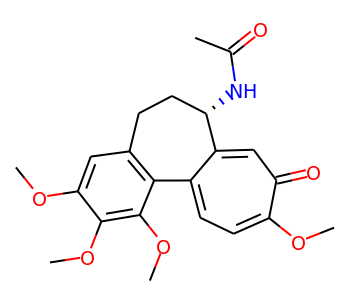

In [2]:
colchicine = Chem.MolFromSmiles('COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC(C)=O)CC2')
colchicine

A quick reminder on what the metadata in the SVG looks like:

In [3]:
dm = Draw.PrepareMolForDrawing(colchicine)
d2d = Draw.MolDraw2DSVG(450,400)
d2d.DrawMolecule(dm)
d2d.AddMoleculeMetadata(dm)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
with open('/tmp/blah.svg','w+') as outf:
    outf.write(svg)

In [4]:
!grep rdkit /tmp/blah.svg

                      xmlns:rdkit='http://www.rdkit.org/xml'
<rdkit:mol xmlns:rdkit = "http://www.rdkit.org/xml" version="0.9">
<rdkit:atom idx="1" atom-smiles="[CH3]" drawing-x="20.4545" drawing-y="222.9" x="-4.30669" y="0.156621" z="0" />
<rdkit:atom idx="2" atom-smiles="[O]" drawing-x="51.1285" drawing-y="261.166" x="-3.68129" y="-0.623579" z="0" />
<rdkit:atom idx="3" atom-smiles="[c]" drawing-x="100.087" drawing-y="253.643" x="-2.68309" y="-0.470179" z="0" />
<rdkit:atom idx="4" atom-smiles="[cH]" drawing-x="116.734" drawing-y="208.951" x="-2.34369" y="0.441021" z="0" />
<rdkit:atom idx="5" atom-smiles="[c]" drawing-x="166.507" drawing-y="202.29" x="-1.32889" y="0.576821" z="0" />
<rdkit:atom idx="6" atom-smiles="[c]" drawing-x="198.132" drawing-y="239.802" x="-0.68409" y="-0.187979" z="0" />
<rdkit:atom idx="7" atom-smiles="[c]" drawing-x="179.828" drawing-y="284.052" x="-1.05729" y="-1.09018" z="0" />
<rdkit:atom idx="8" atom-smiles="[O]" drawing-x="210.668" drawing-y="322.809" 

Ok, let's move onto PNGs.
Start by getting a PIL Image object with the molecule drawing. There's a convenience function for this:

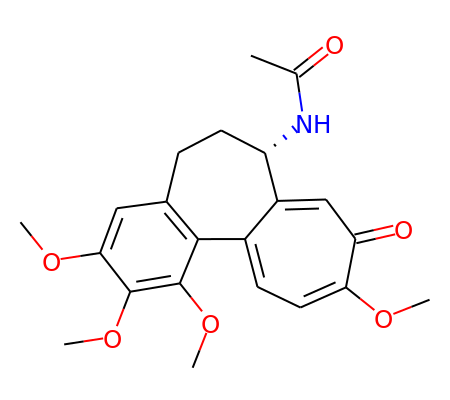

In [5]:
img = Draw.MolToImage(dm,size=(450,400))
img

Now use the PngImagePlugin which is part of pillow to add CXSMILES as the metadata and write the PNG out to a file:

In [6]:
from PIL.PngImagePlugin import PngInfo
metadata = PngInfo()
metadata.add_text("RDKit_SMILES",Chem.MolToCXSmiles(dm))
img.save("/tmp/blah.png",format="PNG",pnginfo=metadata)

Confirm that we can access the metadata when we read the file back in:

In [7]:
nimg = Image.open('/tmp/blah.png')
nimg.text

{'RDKit_SMILES': 'COc1cc2c(-c3ccc(OC)c(=O)cc3[C@@H](NC(C)=O)CC2)c(OC)c1OC |(-4.30669,0.156621,;-3.68129,-0.623579,;-2.68309,-0.470179,;-2.34369,0.441021,;-1.32889,0.576821,;-0.68409,-0.187979,;0.27171,-0.186179,;0.52551,-1.16158,;1.40091,-1.58258,;2.32971,-1.17158,;3.10331,-1.78918,;4.03411,-1.42338,;2.52231,-0.182779,;3.50711,0.0420207,;1.92331,0.619821,;0.93211,0.590821,;0.67991,1.56562,;1.46991,2.19622,;1.32211,3.18522,;0.39191,3.55222,;2.10511,3.80762,;-0.21529,2.02862,;-1.08509,1.57442,;-1.05729,-1.09018,;-0.42849,-1.88038,;-0.79549,-2.81058,;-2.06789,-1.25978,;-2.42669,-2.18238,;-3.41509,-2.33478,)|'}

1


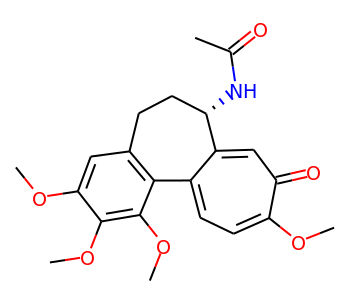

In [8]:
tmol = Chem.MolFromSmiles(nimg.text['RDKit_SMILES'])
print(tmol.GetNumConformers())
tmol

And demonstrate that this isn't just something the PIL tools can read... show the metadata using imagemagick:

In [9]:
!identify -verbose /tmp/blah.png | grep RDK

    RDKit_SMILES: COc1cc2c(-c3ccc(OC)c(=O)cc3[C@@H](NC(C)=O)CC2)c(OC)c1OC |(-4.30669,0.156621,;-3.68129,-0.623579,;-2.68309,-0.470179,;-2.34369,0.441021,;-1.32889,0.576821,;-0.68409,-0.187979,;0.27171,-0.186179,;0.52551,-1.16158,;1.40091,-1.58258,;2.32971,-1.17158,;3.10331,-1.78918,;4.03411,-1.42338,;2.52231,-0.182779,;3.50711,0.0420207,;1.92331,0.619821,;0.93211,0.590821,;0.67991,1.56562,;1.46991,2.19622,;1.32211,3.18522,;0.39191,3.55222,;2.10511,3.80762,;-0.21529,2.02862,;-1.08509,1.57442,;-1.05729,-1.09018,;-0.42849,-1.88038,;-0.79549,-2.81058,;-2.06789,-1.25978,;-2.42669,-2.18238,;-3.41509,-2.33478,)|


Since people inevitably want to put structures into Powerpoint, make sure that we can safely add these and not lose the metadata. I will use the [python-pptx library](https://python-pptx.readthedocs.io/en/latest/index.html) to demo this.

In [10]:
from pptx import Presentation
from pptx.util import Mm

bio = BytesIO()
img.save(bio,format="PNG",pnginfo=metadata)

prs = Presentation()
blank_slide_layout = prs.slide_layouts[6]
slide = prs.slides.add_slide(blank_slide_layout)

left = top = Mm(50)
pic = slide.shapes.add_picture(bio, left, top, height=Mm(60))

prs.save('/tmp/test.pptx')

Make sure we don't lose the metadata:

In [11]:
nprs = Presentation('/tmp/test.pptx')
slide = nprs.slides[0]
pic = slide.shapes[0]
bio = BytesIO(pic.image.blob)
nimg = Image.open(bio)
nimg.text

{'RDKit_SMILES': 'COc1cc2c(-c3ccc(OC)c(=O)cc3[C@@H](NC(C)=O)CC2)c(OC)c1OC |(-4.30669,0.156621,;-3.68129,-0.623579,;-2.68309,-0.470179,;-2.34369,0.441021,;-1.32889,0.576821,;-0.68409,-0.187979,;0.27171,-0.186179,;0.52551,-1.16158,;1.40091,-1.58258,;2.32971,-1.17158,;3.10331,-1.78918,;4.03411,-1.42338,;2.52231,-0.182779,;3.50711,0.0420207,;1.92331,0.619821,;0.93211,0.590821,;0.67991,1.56562,;1.46991,2.19622,;1.32211,3.18522,;0.39191,3.55222,;2.10511,3.80762,;-0.21529,2.02862,;-1.08509,1.57442,;-1.05729,-1.09018,;-0.42849,-1.88038,;-0.79549,-2.81058,;-2.06789,-1.25978,;-2.42669,-2.18238,;-3.41509,-2.33478,)|'}

And to be super sure, I opened the file in PPT in Office365, added some text, and then re-downloaded it

In [12]:
nprs = Presentation('/home/glandrum/Downloads/test.pptx')
slide = nprs.slides[0]
pic = slide.shapes[0]
bio = BytesIO(pic.image.blob)
nimg = Image.open(bio)
nimg.text

{'RDKit_SMILES': 'COc1cc2c(-c3ccc(OC)c(=O)cc3[C@@H](NC(C)=O)CC2)c(OC)c1OC |(-4.30669,0.156621,;-3.68129,-0.623579,;-2.68309,-0.470179,;-2.34369,0.441021,;-1.32889,0.576821,;-0.68409,-0.187979,;0.27171,-0.186179,;0.52551,-1.16158,;1.40091,-1.58258,;2.32971,-1.17158,;3.10331,-1.78918,;4.03411,-1.42338,;2.52231,-0.182779,;3.50711,0.0420207,;1.92331,0.619821,;0.93211,0.590821,;0.67991,1.56562,;1.46991,2.19622,;1.32211,3.18522,;0.39191,3.55222,;2.10511,3.80762,;-0.21529,2.02862,;-1.08509,1.57442,;-1.05729,-1.09018,;-0.42849,-1.88038,;-0.79549,-2.81058,;-2.06789,-1.25978,;-2.42669,-2.18238,;-3.41509,-2.33478,)|'}

Looks good!